In [105]:
from src.files.blast import BLASTJsonFile
from src.files.fasta import FASTAFile, get_reverse_complement
import re
import os 
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
from src.download import *
from src.stop_codon import *

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
def parse_coordinates(coords:str):
    coords = coords.replace('&lt;', '<').replace('&gt;', '>')
    match = re.search(r'([\d<>]+)\.\.([\d<>]+)', coords)
    strand = '-' if 'complement' in coords else '+'

    coords = [match.group(1), match.group(2)]

    partial = ['0', '0']
    for i, coord in enumerate(coords):
        if ('<' in coord) or ('>' in coord):
            partial[i] = '1'
            coords[i] = coord.replace('<', '').replace('>', '')

    start, stop = coords
    return start, stop, strand, ''.join(partial)


def remove_nuccore_duplicates(arf12_df:pd.DataFrame):
    get_nuccore_id = lambda nuccore_id : nuccore_id.replace('NZ_', '').replace('_', '').split('.')[0]
    is_reference = lambda nuccore_id : nuccore_id.startswith('NZ_')
    
    arf12_df['reference'] = arf12_df.nuccore_id.apply(is_reference)
    arf12_df = arf12_df.sort_values('reference', ascending=False) # Sort so that the reference sequences are first. 
    arf12_df['nuccore_id_'] = arf12_df.nuccore_id.apply(get_nuccore_id)
    arf12_df = arf12_df.drop_duplicates('nuccore_id_')
    print('remove_nuccore_duplicates: Num. sequences derived from unique nuccore entries:', len(arf12_df))
    return arf12_df 


Num. BLAST hits: 549
Num. BLAST hits meeting the bit score threshold: 101


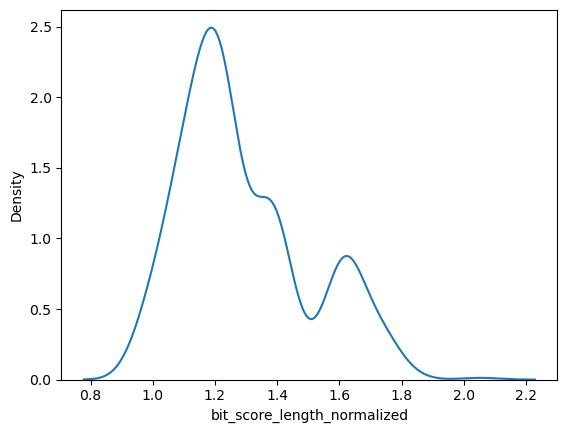

In [107]:
blast_df = BLASTJsonFile('../data/arf1-2.json').to_df()
blast_df = blast_df.drop_duplicates('subject_id')
print('Num. BLAST hits:', len(blast_df))

blast_df['bit_score_length_normalized'] = blast_df.bit_score / blast_df.alignment_length
sns.kdeplot(blast_df, x='bit_score_length_normalized')
blast_df = blast_df[blast_df.bit_score_length_normalized > 1.5].copy()
print('Num. BLAST hits meeting the bit score threshold:', len(blast_df))

In [108]:
if not os.path.exists('../data/arf1-2.csv'):
    arf12_df = list()
    for id_ in tqdm(blast_df.subject_id, desc='Downloading aRF1-2 sequences...'):
        if id_.startswith('WP'):
            arf12_df += download_nr_protein_info(id_)
        else:
            arf12_df += [download_protein_info(id_)]

    arf12_df = pd.DataFrame(arf12_df).set_index('id')
    arf12_df.to_csv('../data/arf1-2.csv')


In [125]:
if not os.path.exists('../data/arf1-2_cleaned.csv'):
    arf12_df = pd.read_csv('../data/arf1-2.csv', index_col=0)
    arf12_df = arf12_df[arf12_df.index.isin(blast_df.subject_id.values)].copy()

    # Go through the ones with string coordinates and parse them all. 
    for row in arf12_df[~arf12_df.coordinates.isnull()].itertuples():
        
        start, stop, strand, partial = parse_coordinates(row.coordinates)
        arf12_df.loc[row.Index, 'start'] = int(start)
        arf12_df.loc[row.Index, 'stop'] = int(stop)
        arf12_df.loc[row.Index, 'strand'] = strand 
        arf12_df.loc[row.Index, 'partial'] = partial

    arf12_df = arf12_df[~arf12_df.nuccore_id.isnull()].copy()
    arf12_df = arf12_df.merge(blast_df.set_index('subject_id'), left_index=True, right_index=True)
    arf12_df = remove_nuccore_duplicates(arf12_df.copy())
    
    arf12_df['seq'] = [download_protein(protein_id) for protein_id in tqdm(arf12_df.index, desc='Downloading protein sequence...')]
    arf12_df['seq'] = arf12_df.seq.str.upper()

    arf12_df['assembly_id'] = [download_assembly_id(nuccore_id) for nuccore_id in tqdm(arf12_df.nuccore_id, desc='Downloading assembly IDs from NCBI.')]
    arf12_df['fn_path'] = [f'../data/ncbi/genomes/{genome_id}.fn' for genome_id in arf12_df.assembly_id]

    nt_seqs = list()
    for row in tqdm(list(arf12_df.itertuples()), desc='Loading nucleotide sequences from FASTA files.'):
        try:
            fasta_file = FASTAFile().from_fasta(row.fn_path)
            nt_seq = fasta_file.get_seq(row.nuccore_id, start=int(row.start) - 1, stop=int(row.stop))
            nt_seq = get_reverse_complement(nt_seq) if (row.strand == '-') else nt_seq
        except:
            print(f'Could not get nucleotide sequence for {row.nuccore_id} in file {row.fn_path}')
            nt_seq = 'none'
        nt_seqs += [nt_seq]
    
    arf12_df['nt_seq'] = nt_seqs
    arf12_df['stop_codon'] = np.where(arf12_df.nt_seq != 'none', arf12_df.nt_seq.str.slice(start=-3), 'none')
    arf12_df['genus'] = arf12_df.organism.apply(lambda org : org.replace('Candidatus', '').split()[0])
    arf12_df = arf12_df[arf12_df.stop_codon.isin(['TAG', 'TGA', 'TAA'])].copy() # Ones without valid stop codons are likely partial.
    

    arf12_df.to_csv('../data/arf1-2_cleaned.csv')

arf12_df = pd.read_csv('../data/arf1-2_cleaned.csv', index_col=0)

FASTAFile().from_df(arf12_df.reset_index()).write('../data/arf1-2.fa')
# ! hmmsearch --tblout ../data/arf1-2.tab ../data/hmms/arf1.hmm ../data/arf1-2.fa
cols = ['target_name', 'accession', 'query_name', '_accession', 'e_value', 'score', 'bias', '_e_value', '_score', '_bias', 'exp', 'reg', 'clu', 'ov', 'env', 'dom', 'rep', 'inc', 'description_of_target']
# cols = ['target_name', 'accession', 'target_length', 'query_name', 'accession_',  'e_value', 'score', 'bias']
hmmer_df = pd.read_csv('../data/arf1-2.tab', sep=r'\s+', comment='#', names=cols)


In [ ]:
min_e_value = 1.7000000000000001e-180
max_e_value = 1.4e-30

# fig, ax = plt.subplots()
# sns.kdeplot(hmmer_df, x='e_value')
# ax.set_xlim(xmax=1e-78, xmin=0)
# ax.axvline(min_e_value, ls='--', color='gray')
# ax.axvline(max_e_value, ls='--', color='gray')
# ax.set_ylabel('density')

mask = (hmmer_df.e_value > min_e_value) & (hmmer_df.e_value < max_e_value)
arf12_ids = hmmer_df[mask].target_name.values
print('Num. sequences in the expected aRF1-2 E-value range:', len(arf12_ids))
arf12_df = arf12_df[arf12_df.index.isin(arf12_ids)].copy()


Num. sequences in the expected aRF1-2 E-value range: 364


In [116]:
genome_ids = arf12_df[arf12_df.assembly_id != 'none'].assembly_id.unique()
# build_stop_codon_genome_metadata_dataset(genome_ids, fn_dir='../data/ncbi/genomes', fa_dir='../data/prodigal', path='../data/arf1-2_stop_codon_genome_metadata.csv')
stop_codon_genome_metadata_df = pd.read_csv('../data/arf1-2_stop_codon_genome_metadata.csv', index_col=0)
stop_codon_genome_metadata_df['tag_percent'] = stop_codon_genome_metadata_df.TAG / stop_codon_genome_metadata_df['total']

arf12_df['tag_percent'] = arf12_df.assembly_id.map(stop_codon_genome_metadata_df.tag_percent)


In [122]:
arf12_df['methanosarcinales'] = arf12_df.genus.str.contains('Methanosarcinales', case=False) | arf12_df.taxonomy.str.contains('Methanosarcinales', case=False)
# arf12_df = arf12_df[arf12_df.methanosarcinales].copy()
arf12_df['genus'] = np.where(arf12_df.genus == 'Methanosarcinales', 'unknown', arf12_df.genus)
arf12_df['genus'] = np.where(arf12_df.genus == 'Methanosarcinaceae', 'unknown', arf12_df.genus) # These are classified as "Methanosarcinaceae archaeaon"
arf12_df['genus'] = np.where(arf12_df.genus == 'Methanobacteriota', 'unknown', arf12_df.genus) # These are classified as "Methanosarcinaceae archaeaon"
arf12_df['recoded'] = arf12_df.tag_percent < 0.05 # ?

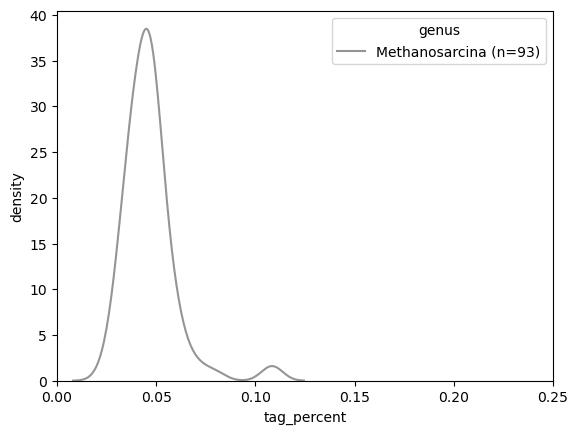

In [123]:
fig, ax = plt.subplots()

genus_counts = arf12_df.genus.value_counts()

figure_df = arf12_df.copy()
figure_df = figure_df[figure_df.genus.isin(genus_counts[genus_counts > 10].index.values)].copy()
figure_df = figure_df.reset_index()
figure_df['genus'] = figure_df.genus.replace({genus:f'{genus} (n={genus_counts.loc[genus]})' for genus in genus_counts.index})
sns.kdeplot(figure_df, x='tag_percent', hue='genus', palette='Grays', common_norm=False)
ax.set_xlim(xmin=0, xmax=0.25)
ax.set_ylabel('density')
plt.show()

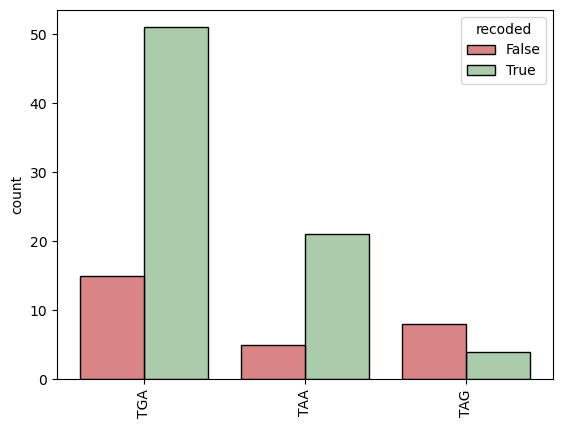

In [124]:

palette = {'TAG':'steelblue', 'TGA':'darkgray', 'TAA':'lightgray'}

genus_counts = arf12_df.genus.value_counts()

fig, ax = plt.subplots()

figure_df = arf12_df.copy()
# figure_df = figure_df[figure_df.recoded].copy()
palette = {True:'darkseagreen', False:'indianred'}
sns.histplot(figure_df, ax=ax, x='stop_codon', hue='recoded', multiple='dodge', shrink=0.8, stat='count', common_norm=True, palette=palette)
ax.set_xticks(ax.get_xticks(), labels=ax.get_xticklabels(), rotation=90)
ax.set_xlabel('')
# ax.set_ylabel('fraction of total')
ax.set_ylabel('count')

# heights = np.array([p.get_height() for p in ax.patches])
# heights = heights / heights.max()
# for p, h in zip(ax.patches, heights):
#     p.set_height(h)
# ax.set_ylim(ymin=0, ymax=1.01)

plt.show()

In [120]:
arf12_df[(arf12_df.stop_codon == 'TAG') & arf12_df.recoded].seq.apply(len)

id
WP_048173561    415
WP_048176655    398
WP_322225704    415
WP_424718648    415
WP_310575472    415
WP_229389239    415
WP_011021044    415
MDY0129076      369
MGA9190051      415
HEY3362554      203
Name: seq, dtype: int64

In [121]:
arf12_df[(arf12_df.genus == 'Methanosarcina') & arf12_df.recoded]

,coordinates,nuccore_id,organism,taxonomy,start,stop,strand,html,partial,subject_description,...,nuccore_id_,seq,assembly_id,fn_path,nt_seq,stop_codon,genus,tag_percent,methanosarcinales,recoded
id,,,,,,,,,,,,,,,,,,,,,
WP_410508283,NaN,NZ_CP136241.1,Methanosarcina hadiensis,NaN,3776033.0,3777280.0,+,"<CDS accver=""NZ_CP136241.1"" start=""3776033"" s...",NaN,peptide chain release factor aRF-1,...,CP136241,MTEHSAHEMYEFKKKLEGLRDKKGRSTELISLYIPSDKQIFDVTNQ...,GCF_046529725.1,../data/ncbi/genomes/GCF_046529725.1.fn,ATGACTGAACATTCCGCACACGAAATGTACGAATTTAAAAAGAAGC...,TGA,Methanosarcina,0.031507,False,True
WP_048185440,NaN,NZ_CP009508.1,Methanosarcina siciliae C2J,NaN,5369271.0,5370518.0,+,"<CDS accver=""NZ_CP009508.1"" start=""5369271"" s...",NaN,peptide chain release factor aRF-1,...,CP009508,MTEQSAHEKYEFKKKLESLRDKKGRSTELISLYIPSDKQIFDVTNQ...,GCF_000970145.1,../data/ncbi/genomes/GCF_000970145.1.fn,ATGACTGAACAATCCGCACACGAGAAATACGAATTTAAAAAGAAGC...,TGA,Methanosarcina,0.058448,False,True
WP_011020101,NaN,NZ_DUJU01000165.1,Methanosarcina acetivorans,NaN,14993.0,16240.0,-,"<CDS accver=""NZ_DUJU01000165.1"" start=""14993""...",NaN,peptide chain release factor aRF-1,...,DUJU01000165,MTEQSAHEKYEFKKKLESLRDKKGRSTELISLYIPADKQIFDVTNQ...,GCF_013329655.1,../data/ncbi/genomes/GCF_013329655.1.fn,ATGACTGAACAATCCGCACACGAGAAATACGAATTTAAAAAGAAGC...,TGA,Methanosarcina,0.050580,False,True
WP_292376749,NaN,NZ_DAKJ01000018.1,Methanosarcina sp. UBA289,NaN,789928.0,791175.0,+,"<CDS accver=""NZ_DAKJ01000018.1"" start=""789928...",NaN,MULTISPECIES: peptide chain release factor aRF-1,...,DAKJ01000018,MTEQSAHEKYEFKKKLESLRDKKGRSTELISLYIPPDKQIFDVTNQ...,GCF_002496565.1,../data/ncbi/genomes/GCF_002496565.1.fn,ATGACTGAACAATCTGCACACGAAAAATACGAATTTAAAAAGAAGC...,TAA,Methanosarcina,0.038250,False,True
WP_292389158,NaN,NZ_DAVG01000080.1,Methanosarcina sp. UBA5,NaN,158891.0,160138.0,-,"<CDS accver=""NZ_DAVG01000080.1"" start=""158891...",NaN,peptide chain release factor aRF-1,...,DAVG01000080,MTEQSAHEKYEFKKKLENLRNKRGRGTELISLYIPHDKQIFDVTNQ...,GCF_002505485.1,../data/ncbi/genomes/GCF_002505485.1.fn,ATGACTGAACAATCTGCACATGAAAAGTACGAATTTAAAAAGAAGC...,TGA,Methanosarcina,0.053081,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WP_048167612,NaN,DAONNY010000012.1,Methanosarcina thermophila,NaN,17328.0,18575.0,-,"<CDS accver=""DAONNY010000012.1"" start=""17328""...",NaN,peptide chain release factor aRF-1,...,DAONNY010000012,MTEQSAHEKYEFKKKLESLRNKKGRSTELISLYIPPDKQIFDVTNQ...,GCA_035408805.1,../data/ncbi/genomes/GCA_035408805.1.fn,ATGACTGAACAATCGGCACATGAGAAATATGAATTTAAAAAGAAGC...,TAA,Methanosarcina,0.041945,False,True
WP_048167612,NaN,JBIOKV010000194.1,Methanosarcina thermophila,NaN,808.0,2055.0,-,"<CDS accver=""JBIOKV010000194.1"" start=""808"" s...",NaN,peptide chain release factor aRF-1,...,JBIOKV010000194,MTEQSAHEKYEFKKKLESLRNKKGRSTELISLYIPPDKQIFDVTNQ...,GCA_044452105.1,../data/ncbi/genomes/GCA_044452105.1.fn,ATGACTGAACAATCGGCACATGAGAAATATGAATTTAAAAAGAAGC...,TAA,Methanosarcina,0.037256,False,True
WP_048167612,NaN,JBASID010000001.1,Methanosarcina thermophila,NaN,145799.0,147046.0,-,"<CDS accver=""JBASID010000001.1"" start=""145799...",NaN,peptide chain release factor aRF-1,...,JBASID010000001,MTEQSAHEKYEFKKKLESLRNKKGRSTELISLYIPPDKQIFDVTNQ...,GCA_049654605.1,../data/ncbi/genomes/GCA_049654605.1.fn,ATGACTGAACAATCGGCACATGAGAAATATGAATTTAAAAAGAAGC...,TAA,Methanosarcina,0.039888,False,True


In [ ]:
# def download_protein_info(id_, fn_dir:str='../data/ncbi/nucleotides'):
    
#     info = list()
    
    # result = Entrez.esearch(db='protein', term=id_, rettype='html').read().decode('utf-8')
    # protein_ids = get_ids(result)
    # if len(protein_ids) == 0:
    #     print(f'download_protein_info: No results for {id_}')
    #     return info
    
#     for protein_id in protein_ids:
#         info = {'id':id_, 'numerical_protein_id':protein_id}
    
#         result = Entrez.efetch(db='protein', id=protein_id, rettype='html').read().decode('utf-8')
#         info['nuccore_id'], info['coordinates'] = get_coordinates(result)
        
#         result = Entrez.elink(dbfrom='protein', db='nuccore', id=protein_id, rettype='html').read().decode('utf-8')
#         nuccore_id = get_ids(result)
#         if len(nuccore_id) == 0:
#             info.append(info)
#             continue 
#         else:
#             nuccore_id = nuccore_id[1] # First ID tag is just the ID itself. 

#         result = Entrez.efetch(db='nuccore', id=nuccore_id, rettype='html').read().decode('utf-8')

#         info['organism'] = get_organism(result)
#         info['taxonomy'] = get_taxonomy(result)
#         # info['nuccore_id'] = get_nuccore_accession(result)
#         info['numerical_nuccore_id'] = nuccore_id

#         fn_path = os.path.join(fn_dir, f'{nuccore_id}.fn')
#         if not os.path.exists(fn_path):
#             result = Entrez.efetch(db='nuccore', id=nuccore_id, rettype='fasta').read()
#             with open(fn_path, 'w') as f:
#                 f.write(result)
#             info['fn_path'] = fn_path
#         info.append(info)
    
#     return info

# arf12_df = list()
# for id_ in tqdm(blast_df.subject_id, desc='Downloading aRF1-2 sequences...'):
#     arf12_df += download_protein_info(id_)
# arf12_df = pd.DataFrame(arf12_df).set_index('id')
